In [1]:
from datetime import datetime, timedelta
from matplotlib.pylab import rcParams
from pandas import DataFrame
from pmdarima.arima import auto_arima, ARIMA
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import PolynomialFeatures
from statistics import mean
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import trange, tqdm, tnrange
from xgboost import plot_importance, plot_tree, XGBClassifier
import datetime as dt
import getpass
import graphviz
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pmdarima as pm
import pycountry
import pycountry_convert as pc
import pydotplus
import pyodbc 
import seaborn as sns
import sklearn.linear_model as lm
import statsmodels.api as sm
import warnings
import xgboost as xgb
pd.options.display.float_format = '{:.2f}'.format   
pd.plotting.register_matplotlib_converters()
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 15, 5

## Data load

In [2]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url)
df = pd.melt(df, id_vars=['Province/State', 'Country/Region','Lat','Long'], var_name='Date', value_name='Confirmed')
df['Date'] = pd.to_datetime(df['Date'])
df.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.00,65.00,2020-01-22,0
1,NaN,Albania,41.15,20.17,2020-01-22,0
2,NaN,Algeria,28.03,1.66,2020-01-22,0
3,NaN,Andorra,42.51,1.52,2020-01-22,0
4,NaN,Angola,-11.20,17.87,2020-01-22,0


In [3]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19988 entries, 0 to 19987
Data columns (total 6 columns):
Province/State    6232 non-null object
Country/Region    19988 non-null object
Lat               19988 non-null float64
Long              19988 non-null float64
Date              19988 non-null datetime64[ns]
Confirmed         19988 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 937.1+ KB


In [4]:
df = df.rename(columns={'Province/State': 'Province', 'Country/Region': 'Country'})
df.shape

(19988, 6)

In [5]:
df_worldwide = pd.DataFrame(df.groupby('Date')['Confirmed'].sum())
df_worldwide['Date'] = df_worldwide.index
df_worldwide = df_worldwide.reset_index(drop=True)
df_worldwide['Country'] = 'Worldwide'
df = df.append(df_worldwide)

In [6]:
df['Province_and_country'] = df['Country'].map(str) + "_" + df['Province'].map(str)
df['Province_and_country'] = df['Province_and_country'].str.replace('_nan', '').map(str)

In [7]:
df['Days_since_outbreak_global'] = df.groupby(['Province_and_country','Lat','Long']).cumcount()+1

In [8]:
df.head()

,Confirmed,Country,Date,Lat,Long,Province,Province_and_country,Days_since_outbreak_global
0,0,Afghanistan,2020-01-22,33.00,65.00,NaN,Afghanistan,1
1,0,Albania,2020-01-22,41.15,20.17,NaN,Albania,1
2,0,Algeria,2020-01-22,28.03,1.66,NaN,Algeria,1
3,0,Andorra,2020-01-22,42.51,1.52,NaN,Andorra,1
4,0,Angola,2020-01-22,-11.20,17.87,NaN,Angola,1


In [9]:
df.to_csv('df_m.CSV',sep=',')

## Analysis - Amount of cases

In [10]:
len(df['Province_and_country'].unique())

264

In [11]:
len(df['Country'].unique())

185

In [12]:
len(df['Province'].unique())

83

In [13]:
df.describe()

,Confirmed,Lat,Long,Days_since_outbreak_global
count,20064.00,19988.00,19988.00,20064.00
mean,1740.49,21.34,22.07,38.50
std,25979.00,24.73,70.65,21.94
min,0.00,-51.80,-135.00,1.00
25%,0.00,6.88,-23.04,19.75
50%,0.00,23.63,20.17,38.50
75%,63.00,41.20,81.00,57.25
max,1345048.00,71.71,178.06,76.00


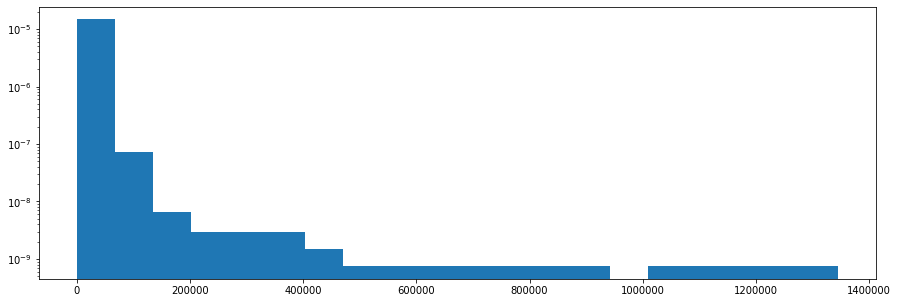

In [14]:
plt.hist(df['Confirmed'], density=True, bins=20) 
plt.yscale('log')

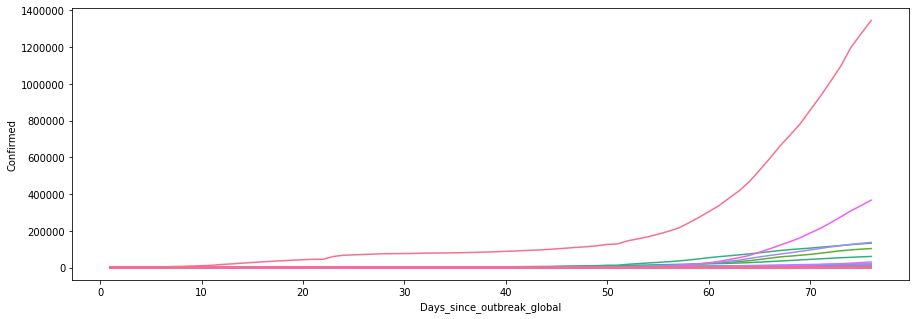

In [15]:
ax=sns.lineplot(data=df, hue="Country", x="Days_since_outbreak_global", y="Confirmed", ci=None)
ax.legend_.remove()

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   67  \
Country                                                             ...        
Afghanistan                  0   0   0   0   0   0   0   0   0   0  ...  110   
Albania                      0   0   0   0   0   0   0   0   0   0  ...  197   
Algeria                      0   0   0   0   0   0   0   0   0   0  ...  454   
Andorra                      0   0   0   0   0   0   0   0   0   0  ...  308   
Angola                       0   0   0   0   0   0   0   0   0   0  ...    5   

Days_since_outbreak_global   68   69   70   71   72    73    74    75    76  
Country                                                                      
Afghanistan                 120  170  174  237  273   281   299   349   367  
Albania                     212  223  243  259  277   304   333   361   377  
Algeria                     511  584  716  847  986  1171  1251  1320  1423  
Andorra                     334  370  376  390  4

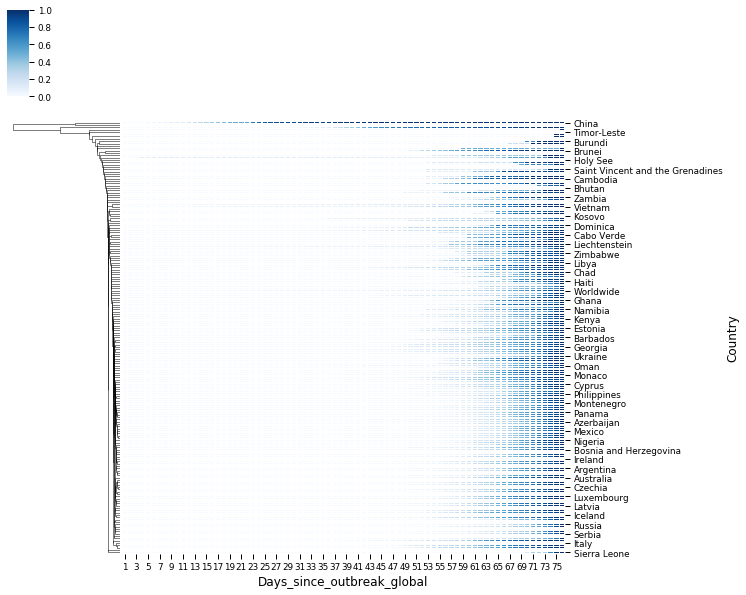

<Figure size 1800x576 with 0 Axes>

In [16]:
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":12,"axes.labelsize":12})   
def group_and_chart(Geography, Figure, Data):
    grouped = Data.groupby(['Days_since_outbreak_global',Geography])[Figure].sum()
    grouped= pd.DataFrame(grouped) 
    grouped.reset_index(inplace=True)
    grouped=grouped.pivot(index='Days_since_outbreak_global', columns=Geography, values=Figure)
    grouped = grouped.T[(grouped != 0).any()].T
    grouped = grouped.transpose()
    grouped.fillna(0, inplace=True)
    print(grouped.head())
    sns.clustermap(grouped, cmap="Blues", linewidth=.5, standard_scale=0,  col_cluster=False, method='single')
    plt.figure(figsize=(25,8))
    
group_and_chart(Geography='Country', Figure='Confirmed', Data=df)

In [17]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv'
df_country = pd.read_csv(url)
df_country = df_country.drop_duplicates(subset=['Country_Region'], keep=False)
df_country

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population
0,4,AF,AFG,4.00,nan,NaN,NaN,Afghanistan,33.94,67.71,Afghanistan,38928341.00
1,8,AL,ALB,8.00,nan,NaN,NaN,Albania,41.15,20.17,Albania,2877800.00
2,12,DZ,DZA,12.00,nan,NaN,NaN,Algeria,28.03,1.66,Algeria,43851043.00
3,20,AD,AND,20.00,nan,NaN,NaN,Andorra,42.51,1.52,Andorra,77265.00
4,24,AO,AGO,24.00,nan,NaN,NaN,Angola,-11.20,17.87,Angola,32866268.00
...,...,...,...,...,...,...,...,...,...,...,...,...
175,704,VN,VNM,704.00,nan,NaN,NaN,Vietnam,14.06,108.28,Vietnam,97338583.00
176,275,PS,PSE,275.00,nan,NaN,NaN,West Bank and Gaza,31.95,35.23,West Bank and Gaza,5101416.00
177,732,EH,ESH,732.00,nan,NaN,NaN,Western Sahara,24.22,-12.89,Western Sahara,597330.00
178,894,ZM,ZMB,894.00,nan,NaN,NaN,Zambia,-13.13,27.85,Zambia,18383956.00


In [18]:
# apply the mapping to df
df = pd.merge(df, df_country[['Country_Region','iso2']], left_on='Country', right_on='Country_Region', how='left')
df

,Confirmed,Country,Date,Lat,Long,Province,Province_and_country,Days_since_outbreak_global,Country_Region,iso2
0,0,Afghanistan,2020-01-22,33.00,65.00,NaN,Afghanistan,1,Afghanistan,AF
1,0,Albania,2020-01-22,41.15,20.17,NaN,Albania,1,Albania,AL
2,0,Algeria,2020-01-22,28.03,1.66,NaN,Algeria,1,Algeria,DZ
3,0,Andorra,2020-01-22,42.51,1.52,NaN,Andorra,1,Andorra,AD
4,0,Angola,2020-01-22,-11.20,17.87,NaN,Angola,1,Angola,AO
...,...,...,...,...,...,...,...,...,...,...
20059,1013157,Worldwide,2020-04-02,nan,nan,NaN,Worldwide,72,NaN,NaN
20060,1095917,Worldwide,2020-04-03,nan,nan,NaN,Worldwide,73,NaN,NaN
20061,1197405,Worldwide,2020-04-04,nan,nan,NaN,Worldwide,74,NaN,NaN
20062,1272115,Worldwide,2020-04-05,nan,nan,NaN,Worldwide,75,NaN,NaN


In [19]:
def alpha2_to_continent(iso):
    try: cont = pc.country_alpha2_to_continent_code(iso)
    except: cont = float('NaN')
    return cont

df['Continent'] = df['iso2'].apply(alpha2_to_continent) # get continent code

df.loc[df['Country'] == "Diamond Princess", 'Continent'] = "Diamond Princess"
df.loc[df['Country'] == "MS Zaandam", 'Continent'] = "MS Zaandam"
df.loc[df['Country'] == "Netherlands", 'Continent'] = "EU"
df.loc[df['Country'] == "Holy See", 'Continent'] = "AS"
df.loc[df['Country'] == "Namibia", 'Continent'] = "AF"
df.loc[df['Country'] == "Timor-Leste", 'Continent'] = "AS"
df.loc[df['Country'] == "Western Sahara", 'Continent'] = "AF"

df['Continent'] = df['Continent'].map({'MS Zaandam':'Ships','Diamond Princess':'Ships','AF':'Africa','AS':'Asia','EU':'Europe','NA':'North America','OC':'Oceania','SA':'South America'})

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...  \
Continent                                                           ...   
Africa                       0   0   0   0   0   0   0   0   0   0  ...   
Asia                         6  10  17  23  30  35  49  56  67  87  ...   
Europe                       0   0   0   0   0   1   4   5   5  11  ...   
North America                0   0   0   0   0   0   0   0   0   0  ...   
Oceania                      0   0   0   0   0   0   0   0   0   0  ...   

Days_since_outbreak_global      67      68      69      70      71      72  \
Continent                                                                    
Africa                        4225    4786    5196    5781    6380    7032   
Asia                         73324   80547   87472   96180  104643  113860   
Europe                      298397  322586  346247  370517  397564  426434   
North America                 2969    3443    3819    4372    4773    5301   
Oceani

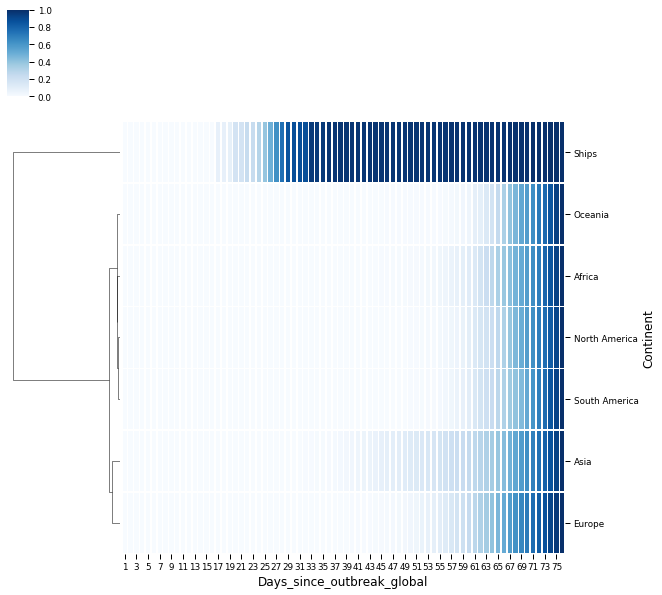

<Figure size 1800x576 with 0 Axes>

In [20]:
group_and_chart(Geography='Continent', Figure='Confirmed', Data=df)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   67  \
Country                                                             ...        
Afghanistan                  0   0   0   0   0   0   0   0   0   0  ...  110   
Armenia                      0   0   0   0   0   0   0   0   0   0  ...  407   
Azerbaijan                   0   0   0   0   0   0   0   0   0   0  ...  182   
Bahrain                      0   0   0   0   0   0   0   0   0   0  ...  476   
Bangladesh                   0   0   0   0   0   0   0   0   0   0  ...   48   

Days_since_outbreak_global   68   69   70   71   72   73   74   75   76  
Country                                                                  
Afghanistan                 120  170  174  237  273  281  299  349  367  
Armenia                     424  482  532  571  663  736  770  822  833  
Azerbaijan                  209  273  298  359  400  443  521  584  641  
Bahrain                     499  515  567  569  643  672  688  700  7

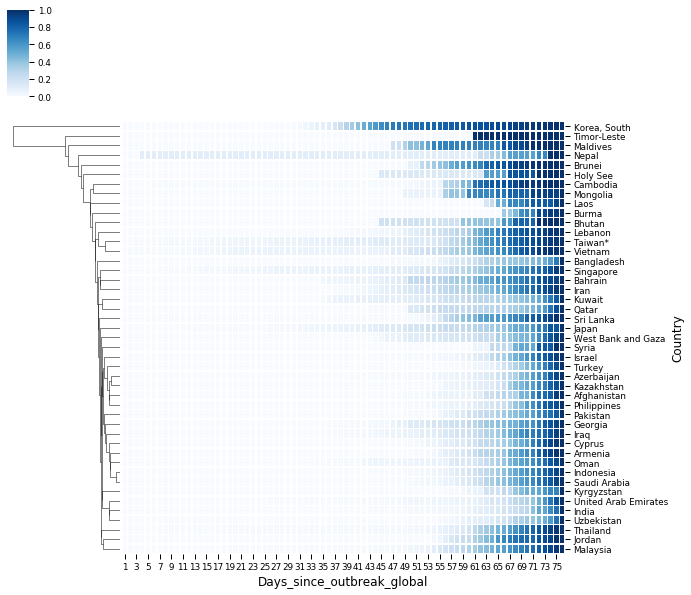

<Figure size 1800x576 with 0 Axes>

In [21]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...    67  \
Country                                                             ...         
Albania                      0   0   0   0   0   0   0   0   0   0  ...   197   
Andorra                      0   0   0   0   0   0   0   0   0   0  ...   308   
Austria                      0   0   0   0   0   0   0   0   0   0  ...  8271   
Belarus                      0   0   0   0   0   0   0   0   0   0  ...    94   
Belgium                      0   0   0   0   0   0   0   0   0   0  ...  9134   

Days_since_outbreak_global     68     69     70     71     72     73     74  \
Country                                                                       
Albania                       212    223    243    259    277    304    333   
Andorra                       334    370    376    390    428    439    466   
Austria                      8788   9618  10180  10711  11129  11524  11781   
Belarus                        94    

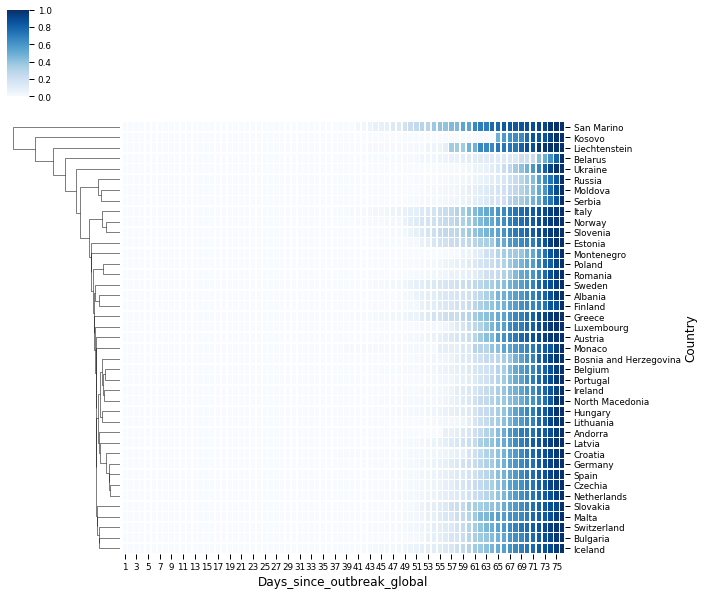

<Figure size 1800x576 with 0 Axes>

In [22]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   67  \
Country                                                             ...        
Algeria                      0   0   0   0   0   0   0   0   0   0  ...  454   
Angola                       0   0   0   0   0   0   0   0   0   0  ...    5   
Benin                        0   0   0   0   0   0   0   0   0   0  ...    6   
Botswana                     0   0   0   0   0   0   0   0   0   0  ...    0   
Burkina Faso                 0   0   0   0   0   0   0   0   0   0  ...  207   

Days_since_outbreak_global   68   69   70   71   72    73    74    75    76  
Country                                                                      
Algeria                     511  584  716  847  986  1171  1251  1320  1423  
Angola                        7    7    7    8    8     8    10    14    16  
Benin                         6    6    9   13   13    16    16    22    26  
Botswana                      0    3    4    4   

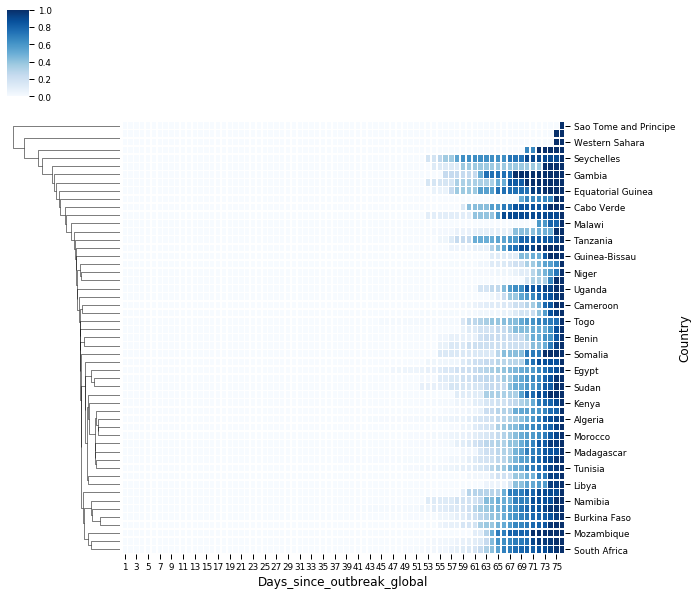

<Figure size 1800x576 with 0 Axes>

In [23]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   67  \
Country                                                             ...        
Antigua and Barbuda          0   0   0   0   0   0   0   0   0   0  ...    7   
Bahamas                      0   0   0   0   0   0   0   0   0   0  ...   10   
Barbados                     0   0   0   0   0   0   0   0   0   0  ...   26   
Belize                       0   0   0   0   0   0   0   0   0   0  ...    2   
Costa Rica                   0   0   0   0   0   0   0   0   0   0  ...  295   

Days_since_outbreak_global   68   69   70   71   72   73   74   75   76  
Country                                                                  
Antigua and Barbuda           7    7    7    7    9   15   15   15   15  
Bahamas                      11   14   14   21   24   24   28   28   29  
Barbados                     33   33   34   34   46   51   52   56   60  
Belize                        2    3    3    3    3    4    4    5   

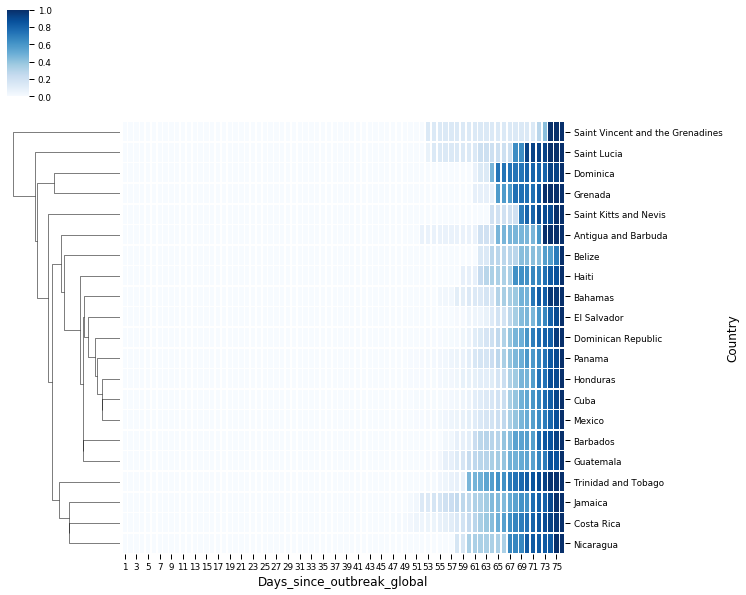

<Figure size 1800x576 with 0 Axes>

In [24]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   67  \
Country                                                             ...        
Fiji                         0   0   0   0   0   0   0   0   0   0  ...    5   
New Zealand                  0   0   0   0   0   0   0   0   0   0  ...  451   
Papua New Guinea             0   0   0   0   0   0   0   0   0   0  ...    1   

Days_since_outbreak_global   68   69   70   71   72   73   74    75    76  
Country                                                                    
Fiji                          5    5    5    5    7    7   12    12    14  
New Zealand                 514  589  647  708  797  868  950  1039  1106  
Papua New Guinea              1    1    1    1    1    1    1     1     2  

[3 rows x 76 columns]


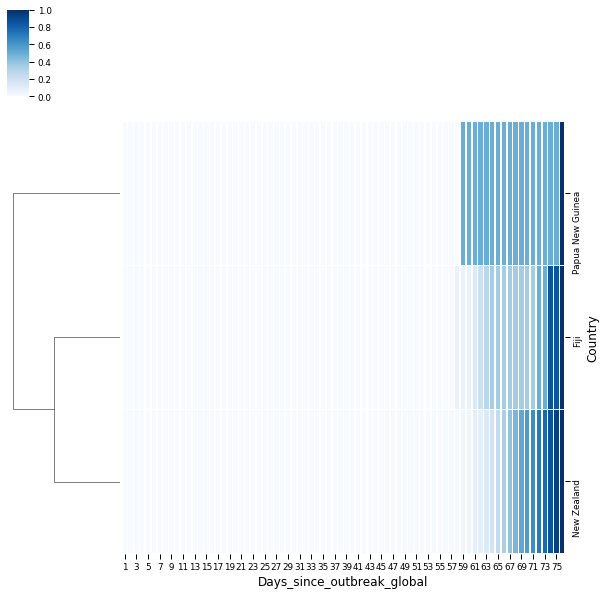

<Figure size 1800x576 with 0 Axes>

In [25]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...    67  \
Country                                                             ...         
Argentina                    0   0   0   0   0   0   0   0   0   0  ...   690   
Bolivia                      0   0   0   0   0   0   0   0   0   0  ...    74   
Brazil                       0   0   0   0   0   0   0   0   0   0  ...  3904   
Chile                        0   0   0   0   0   0   0   0   0   0  ...  1909   
Colombia                     0   0   0   0   0   0   0   0   0   0  ...   608   

Days_since_outbreak_global    68    69    70    71    72    73     74     75  \
Country                                                                        
Argentina                    745   820  1054  1054  1133  1265   1451   1451   
Bolivia                       81    97   107   115   123   132    139    157   
Brazil                      4256  4579  5717  6836  8044  9056  10360  11130   
Chile                       2139

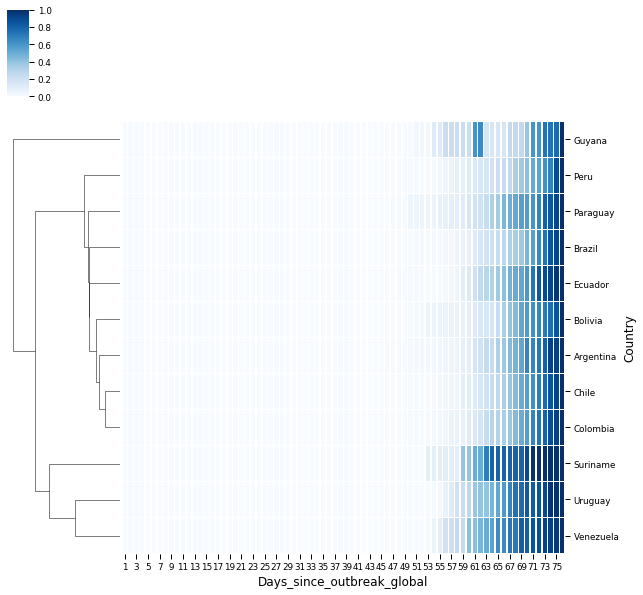

<Figure size 1800x576 with 0 Axes>

In [26]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

## Analysis - daily increase

In [27]:
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Week_number'] = df['Date'].dt.week
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Confirmed_lag_1'] = df.groupby('Province_and_country')['Confirmed'].shift(1)
df['Daily_increase_confirmed'] = (df['Confirmed']/df['Confirmed_lag_1'])-1
df = df.replace([np.inf, -np.inf], np.nan)
#df.loc[df['Daily_increase_confirmed'] == np.inf, 'Daily_increase_confirmed'] = df['Confirmed']
#df.loc[df['Daily_increase_death'] == np.inf, 'Daily_increase_death'] = df['Deaths']
df = df.replace(np.nan, 0)
df

,Confirmed,Country,Date,Lat,Long,Province,Province_and_country,Days_since_outbreak_global,Country_Region,iso2,Continent,Day,Weekday,Week_number,Quarter,Month,Year,Confirmed_lag_1,Daily_increase_confirmed
0,0,Afghanistan,2020-01-22,33.00,65.00,0,Afghanistan,1,Afghanistan,AF,Asia,22,2,4,1,1,2020,0.00,0.00
1,0,Albania,2020-01-22,41.15,20.17,0,Albania,1,Albania,AL,Europe,22,2,4,1,1,2020,0.00,0.00
2,0,Algeria,2020-01-22,28.03,1.66,0,Algeria,1,Algeria,DZ,Africa,22,2,4,1,1,2020,0.00,0.00
3,0,Andorra,2020-01-22,42.51,1.52,0,Andorra,1,Andorra,AD,Europe,22,2,4,1,1,2020,0.00,0.00
4,0,Angola,2020-01-22,-11.20,17.87,0,Angola,1,Angola,AO,Africa,22,2,4,1,1,2020,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20059,1013157,Worldwide,2020-04-02,0.00,0.00,0,Worldwide,72,0,0,0,2,3,14,2,4,2020,932605.00,0.09
20060,1095917,Worldwide,2020-04-03,0.00,0.00,0,Worldwide,73,0,0,0,3,4,14,2,4,2020,1013157.00,0.08
20061,1197405,Worldwide,2020-04-04,0.00,0.00,0,Worldwide,74,0,0,0,4,5,14,2,4,2020,1095917.00,0.09
20062,1272115,Worldwide,2020-04-05,0.00,0.00,0,Worldwide,75,0,0,0,5,6,14,2,4,2020,1197405.00,0.06


In [28]:
df.to_csv('df_m.CSV',sep=',')

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Albania                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Algeria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Andorra                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Angola                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...   67   68   69   70   71   72   73   74   75  \
Country                     ...                                                
Afghanistan                 ... 0.00 0.09 0.42 0.02 0.36 0.15 0.03 0.06 0.17   
Albania                     ... 0.06 0.08 0.05 0.09 0.07 0.07 0.10 0.10 0.08   
Algeria                     ... 0.11 0.13 0.14 0.23 0.18 0.16 0.19 0.07 0.06   
Andorra                     ... 0.15 0.

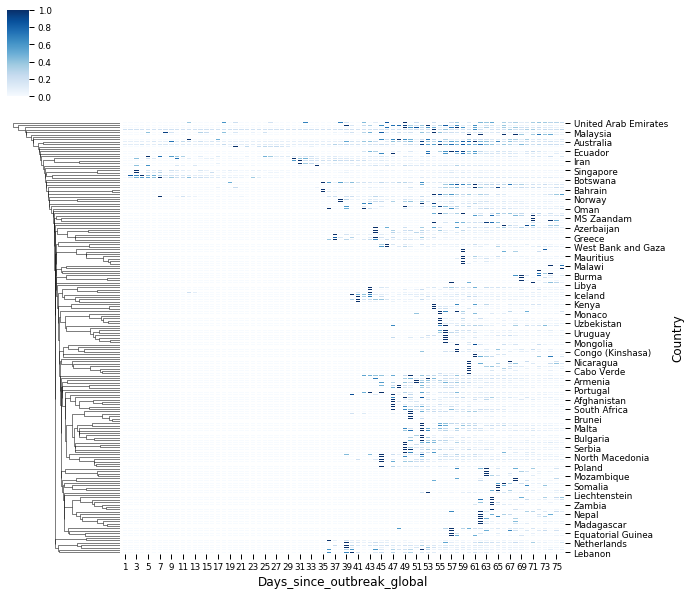

<Figure size 1800x576 with 0 Axes>

In [29]:
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global   1     2     3     4     5     6     7    8   \
Continent                                                                  
0                          0.00 32.56 27.39 40.13 19.28 19.91 14.42 7.08   
Africa                     0.00  0.00  0.00  0.00  0.00  0.00  0.00 0.00   
Asia                       0.00  0.50  5.67  0.40  2.64  0.83  2.50 0.75   
Europe                     0.00  0.00  0.00  0.00  0.00  0.00  3.00 0.00   
North America              0.00  0.00  0.00  0.00  0.00  0.00  0.00 0.00   

Days_since_outbreak_global    9     10  ...   67    68   69   70   71   72  \
Continent                               ...                                  
0                          11.12 10.03  ... 6.70  3.65 6.35 4.70 5.27 5.02   
Africa                      0.00  0.00  ... 7.55 13.51 7.39 8.12 8.25 5.10   
Asia                        1.27  2.88  ... 5.11  5.57 3.77 3.60 3.82 5.22   
Europe                      0.00  0.25  ... 5.12  5.11 4.22 4.02 5.20 4.81   

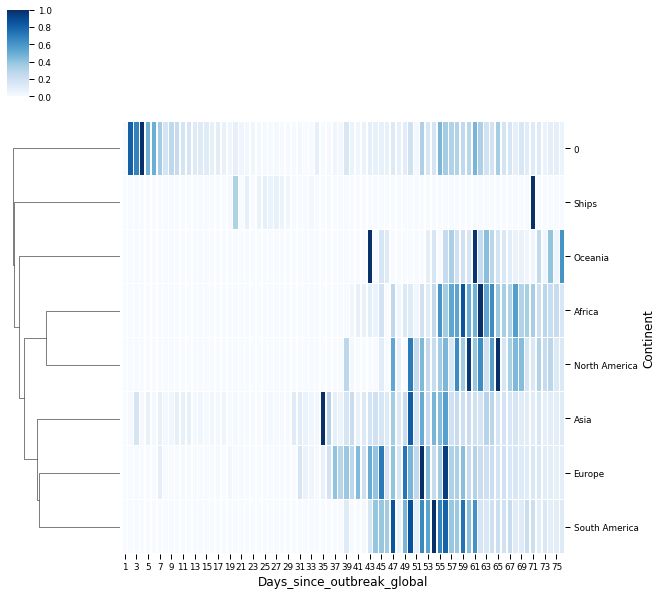

<Figure size 1800x576 with 0 Axes>

In [30]:
group_and_chart(Geography='Continent', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Armenia                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Azerbaijan                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bahrain                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bangladesh                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...   67   68   69   70   71   72   73   74   75  \
Country                     ...                                                
Afghanistan                 ... 0.00 0.09 0.42 0.02 0.36 0.15 0.03 0.06 0.17   
Armenia                     ... 0.24 0.04 0.14 0.10 0.07 0.16 0.11 0.05 0.07   
Azerbaijan                  ... 0.10 0.15 0.31 0.09 0.20 0.11 0.11 0.18 0.12   
Bahrain                     ... 0.02 0.

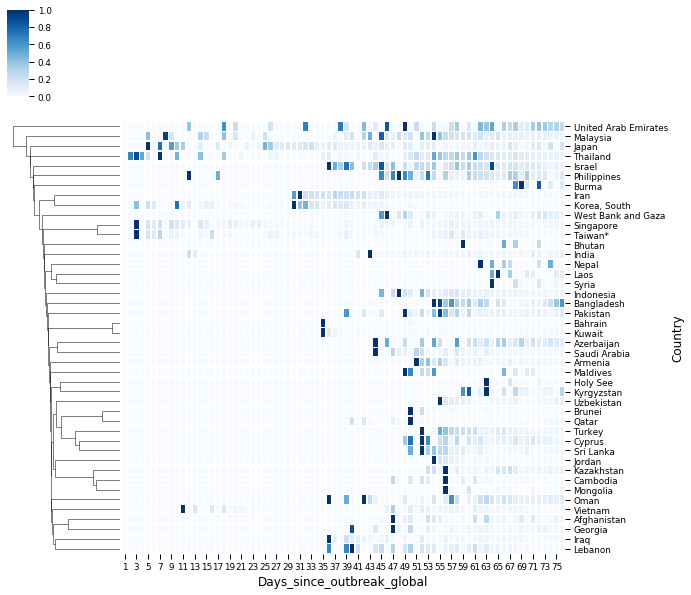

<Figure size 1800x576 with 0 Axes>

In [31]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Albania                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Andorra                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Austria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belarus                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belgium                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...   67   68   69   70   71   72   73   74   75  \
Country                     ...                                                
Albania                     ... 0.06 0.08 0.05 0.09 0.07 0.07 0.10 0.10 0.08   
Andorra                     ... 0.15 0.08 0.11 0.02 0.04 0.10 0.03 0.06 0.08   
Austria                     ... 0.08 0.06 0.09 0.06 0.05 0.04 0.04 0.02 0.02   
Belarus                     ... 0.00 0.

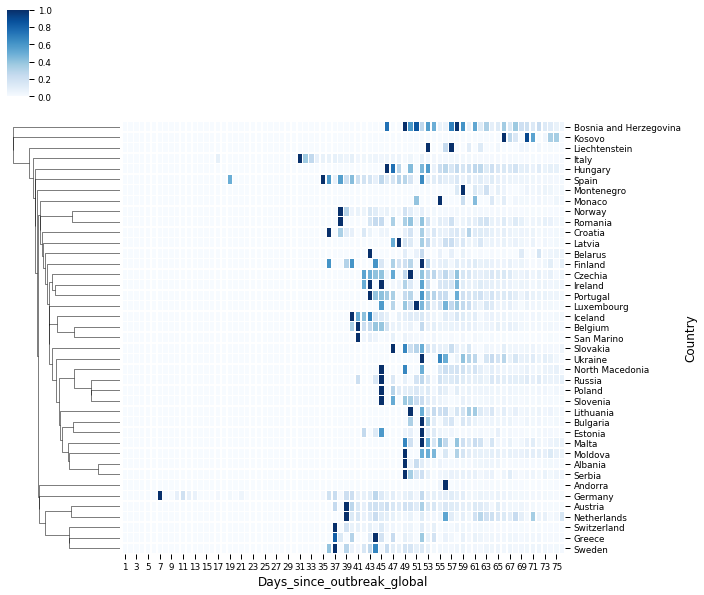

<Figure size 1800x576 with 0 Axes>

In [32]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Algeria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Angola                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Benin                      0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Botswana                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Burkina Faso               0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...   67   68   69   70   71   72   73   74   75  \
Country                     ...                                                
Algeria                     ... 0.11 0.13 0.14 0.23 0.18 0.16 0.19 0.07 0.06   
Angola                      ... 0.25 0.40 0.00 0.00 0.14 0.00 0.00 0.25 0.40   
Benin                       ... 0.00 0.00 0.00 0.50 0.44 0.00 0.23 0.00 0.38   
Botswana                    ... 0.00 0.

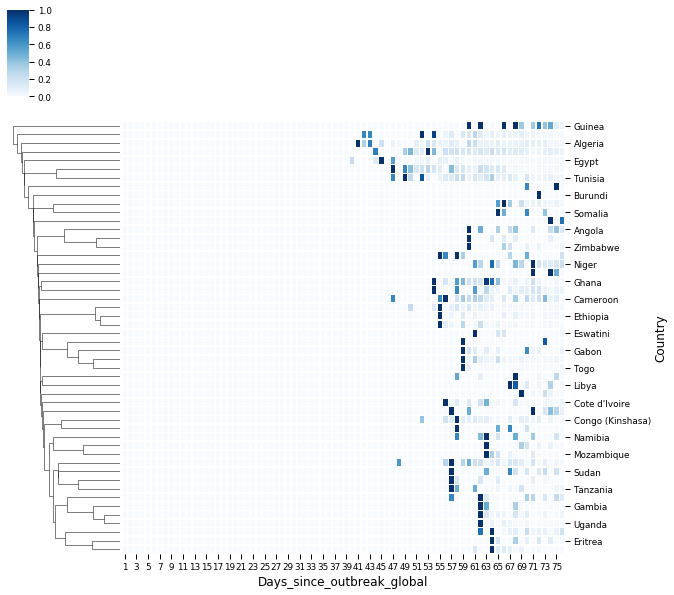

<Figure size 1800x576 with 0 Axes>

In [33]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Antigua and Barbuda        0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bahamas                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Barbados                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belize                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Costa Rica                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...   67   68   69   70   71   72   73   74   75  \
Country                     ...                                                
Antigua and Barbuda         ... 0.00 0.00 0.00 0.00 0.00 0.29 0.67 0.00 0.00   
Bahamas                     ... 0.00 0.10 0.27 0.00 0.50 0.14 0.00 0.17 0.00   
Barbados                    ... 0.08 0.27 0.00 0.03 0.00 0.35 0.11 0.02 0.08   
Belize                      ... 0.00 0.

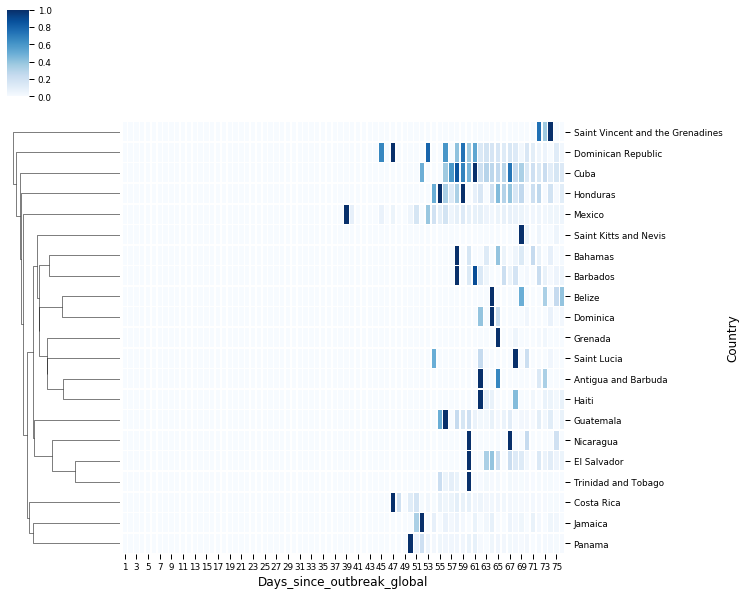

<Figure size 1800x576 with 0 Axes>

In [34]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Fiji                       0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
New Zealand                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Papua New Guinea           0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...   67   68   69   70   71   72   73   74   75  \
Country                     ...                                                
Fiji                        ... 0.00 0.00 0.00 0.00 0.00 0.40 0.00 0.71 0.00   
New Zealand                 ... 0.23 0.14 0.15 0.10 0.09 0.13 0.09 0.09 0.09   
Papua New Guinea            ... 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global   76  
Country                          
Fiji                       0.17  
New Zealand                0.06  
Papua New Guinea           1.00  

[3 rows x 76 columns]


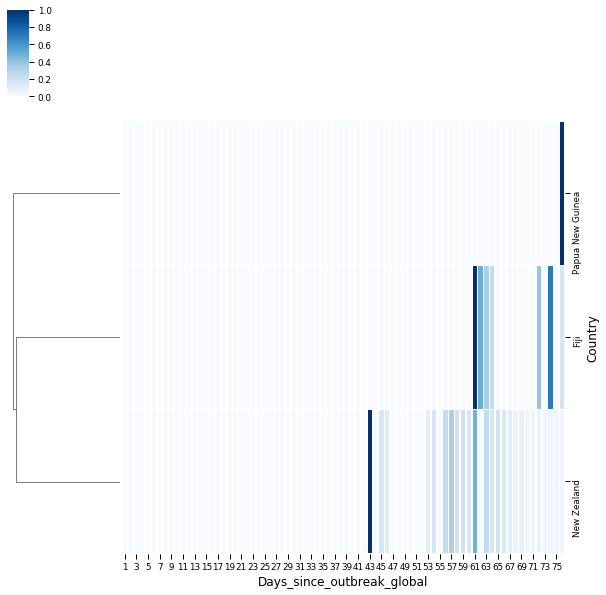

<Figure size 1800x576 with 0 Axes>

In [35]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Argentina                  0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bolivia                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Brazil                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Chile                      0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Colombia                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...   67   68   69   70   71   72   73   74   75  \
Country                     ...                                                
Argentina                   ... 0.17 0.08 0.10 0.29 0.00 0.07 0.12 0.15 0.00   
Bolivia                     ... 0.21 0.09 0.20 0.10 0.07 0.07 0.07 0.05 0.13   
Brazil                      ... 0.14 0.09 0.08 0.25 0.20 0.18 0.13 0.14 0.07   
Chile                       ... 0.19 0.

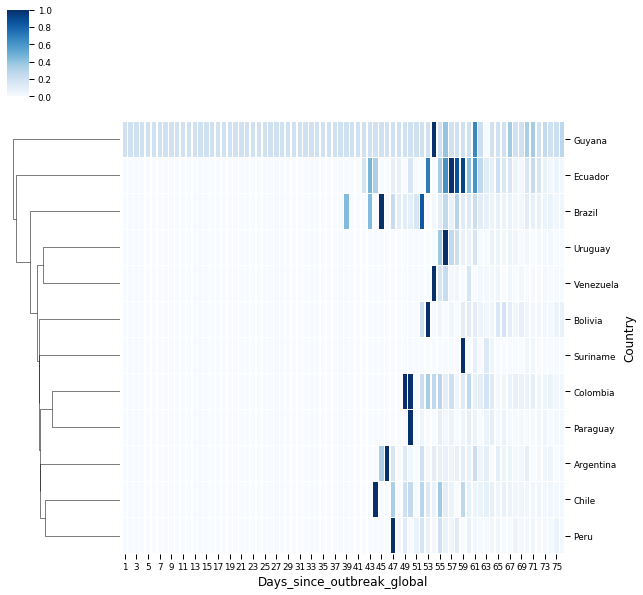

<Figure size 1800x576 with 0 Axes>

In [36]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

## Prediction

In [37]:
#Confirmed
df_ml_confirmed = df
df_ml_confirmed['Confirmed_lag_7'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed'].shift(7)
df_ml_confirmed['Days_since_outbreak_country'] = df_ml_confirmed.loc[(df_ml_confirmed.Confirmed.notnull())].groupby(['Province_and_country','Lat','Long']).cumcount()+1
df_ml_confirmed = df_ml_confirmed.replace(np.nan, 0)
df_ml_confirmed = df_ml_confirmed[['Confirmed', 'Province_and_country', 'Days_since_outbreak_global', 'Date','Day','Weekday','Week_number','Quarter','Month','Year', 'Confirmed_lag_7','Days_since_outbreak_country']]

In [38]:
df_ml_confirmed.to_csv('df_ml.CSV',sep=',')

### One Country Test

In [39]:
split_date = datetime.today() - timedelta(days=8)
split_date

datetime.datetime(2020, 3, 30, 21, 34, 52, 635509)

In [40]:
def create_x_y(df, label=None):
    df.index = df['Date']
    X = df[['Days_since_outbreak_global','Day','Weekday','Week_number','Quarter','Month','Year', 'Confirmed_lag_7','Days_since_outbreak_country']]
    if label:
        y = df[label]
        return X, y
    return X

30135.307297120686
173.5952398457996
2.7814746601947413


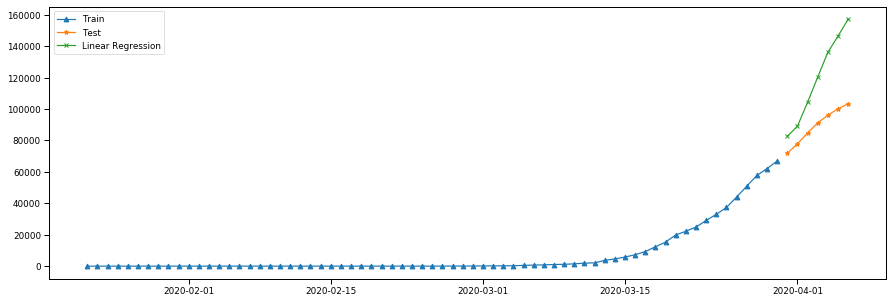

In [41]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

linear_regressor.fit(X_train, y_train)

Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='Linear Regression', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))

3390.193877963763
58.22537142830231
0.31291329707477467


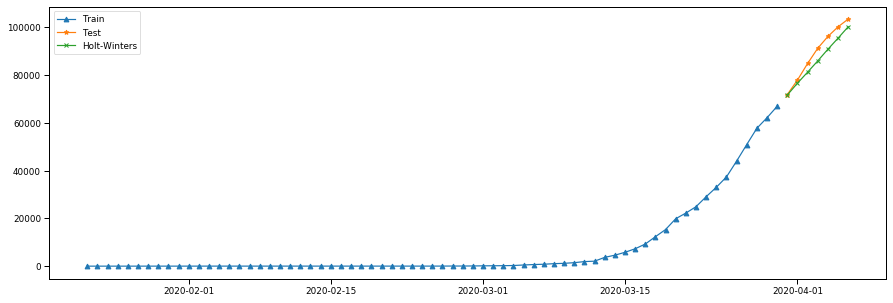

In [42]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model

hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

pred = hw_model.predict(start=test.index[0], end=test.index[-1])
pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_absolute_error(y_pred=pred, y_true=test)))
print(SDMAE(y_pred=pred.Confirmed, y_true=test.Confirmed))

In [43]:
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

cfg_list = exp_smoothing_configs(seasonal=[6]) #[0,6,12]

In [44]:
edf = List['Confirmed']
ts = edf[:split_date].copy()
ts_v = edf[split_date:].copy()
ind = edf.index[-7:]  

print("Holt's Winter Model")
best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    print(j)
    try:
        cg = cfg_list[j]
        print(cg)
        t,d,s,p,b,r = cg
        train = edf[:split_date].copy()
        test = edf[split_date:split_date+timedelta(days=7)].copy()
        # define model
        if (t == None):
            model = ExponentialSmoothing(ts, trend=t, seasonal=s, seasonal_periods=p)
        else:
            model = ExponentialSmoothing(ts, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        # fit model
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        # make one step forecast
        y_forecast = model_fit.forecast(7)
        rmse = np.sqrt(mean_squared_error(ts_v,y_forecast))
        print(rmse)
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        continue

Holt's Winter Model
0
['add', True, 'add', 6, True, True]
1
['add', True, 'add', 6, True, False]
2
['add', True, 'add', 6, False, True]
3530.2569421841695
3
['add', True, 'add', 6, False, False]
3607.3539704795976
4
['add', True, 'mul', 6, True, True]
5
['add', True, 'mul', 6, True, False]
6
['add', True, 'mul', 6, False, True]
7
['add', True, 'mul', 6, False, False]
8
['add', True, None, 6, True, True]
9
['add', True, None, 6, True, False]
10
['add', True, None, 6, False, True]
3609.0849480504266
11
['add', True, None, 6, False, False]
3683.7187430915233
12
['add', False, 'add', 6, True, True]
13
['add', False, 'add', 6, True, False]
14
['add', False, 'add', 6, False, True]
3530.2569421841695
15
['add', False, 'add', 6, False, False]
3607.3539704795976
16
['add', False, 'mul', 6, True, True]
17
['add', False, 'mul', 6, True, False]
18
['add', False, 'mul', 6, False, True]
19
['add', False, 'mul', 6, False, False]
20
['add', False, None, 6, True, True]
21
['add', False, None, 6, True, 

In [45]:
def model_eval(y, predictions):

    # Import library for metrics
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Mean absolute error (MAE)
    mae = mean_absolute_error(y, predictions)

    # Mean squared error (MSE)
    mse = mean_squared_error(y, predictions)


    # SMAPE is an alternative for MAPE when there are zeros in the testing data. It
    # scales the absolute percentage by the sum of forecast and observed values
    SMAPE = np.mean(np.abs((y - predictions) / ((y + predictions)/2))) * 100


    # Calculate the Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y, predictions))

    # Calculate the Mean Absolute Percentage Error
    # y, predictions = check_array(y, predictions)
    MAPE = np.mean(np.abs((y - predictions) / y)) * 100

    # mean_forecast_error
    mfe = np.mean(y - predictions)

    # NMSE normalizes the obtained MSE after dividing it by the test variance. It
    # is a balanced error measure and is very effective in judging forecast
    # accuracy of a model.

    # normalised_mean_squared_error
    NMSE = mse / (np.sum((y - np.mean(y)) ** 2)/(len(y)-1))


    # theil_u_statistic
    # It is a normalized measure of total forecast error.
    error = y - predictions
    mfe = np.sqrt(np.mean(predictions**2))
    mse = np.sqrt(np.mean(y**2))
    rmse = np.sqrt(np.mean(error**2))
    theil_u_statistic =  rmse / (mfe*mse)


    # mean_absolute_scaled_error
    # This evaluation metric is used to over come some of the problems of MAPE and
    # is used to measure if the forecasting model is better than the naive model or
    # not.


    # Print metrics
    print('Mean Absolute Error:', round(mae, 3))
    print('Mean Squared Error:', round(mse, 3))
    print('Root Mean Squared Error:', round(rmse, 3))
    print('Mean absolute percentage error:', round(MAPE, 3))
    print('Scaled Mean absolute percentage error:', round(SMAPE, 3))
    print('Mean forecast error:', round(mfe, 3))
    print('Normalised mean squared error:', round(NMSE, 3))
    print('Theil_u_statistic:', round(theil_u_statistic, 3))

In [46]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('01-Apr-2019'), end = pd.to_datetime('29-Feb-2020'))
pred_HW = fit2.forecast(7)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([List, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW))
print('-*-'*20)

# 15.570830579664698 ['add', True, 'add', 12, False, False]
# Mean Absolute Error: 10.456
# Mean Squared Error: 481.948
# Root Mean Squared Error: 15.571
# Mean absolute percentage error: 2.317
# Scaled Mean absolute percentage error: 2.273
# Mean forecast error: 483.689
# Normalised mean squared error: 0.04
# Theil_u_statistic: 0.0
# None
# -*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

3530.2569421841695 ['add', True, 'add', 6, False, True]
Mean Absolute Error: 3071.286
Mean Squared Error: 89972.134
Root Mean Squared Error: 3530.257
Mean absolute percentage error: 3.294
Scaled Mean absolute percentage error: 3.366
Mean forecast error: 86782.1
Normalised mean squared error: 0.091
Theil_u_statistic: 0.0
None
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


3071.2862807326246
55.41918693676969
0.28347827615740856


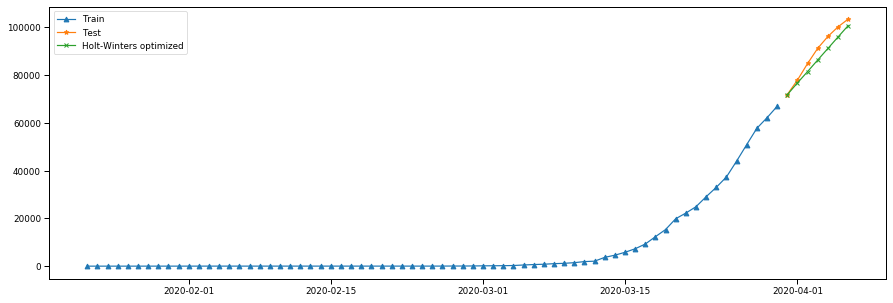

In [47]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=6, damped=False) #Tuned_model

hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

pred = hw_model.predict(start=test.index[0], end=test.index[-1])
pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters optimized', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_absolute_error(y_pred=pred, y_true=test)))
print(SDMAE(y_pred=pred.Confirmed, y_true=test.Confirmed))

#['add', False, 'add', 6, False, True]
# t1,d1,s1,p1,b1,r1

3272.4285714285716
57.20514462378861
0.3020436147865506


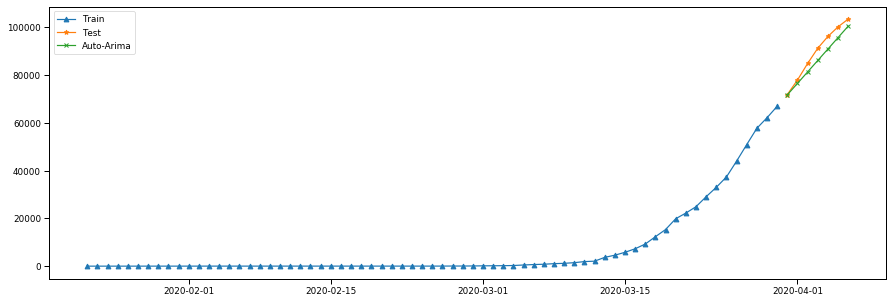

In [48]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

stepwise_fit = auto_arima(train, error_action='ignore', trace=False,
                      suppress_warnings=True, maxiter=100,
                      seasonal=True, stepwise=True)  # set to stepwise

stepwise_fit.summary()

pred = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= test.index)

pred.columns = ['Confirmed']

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Auto-Arima', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_absolute_error(y_pred=pred, y_true=test)))
print(SDMAE(y_pred=pred.Confirmed, y_true=test.Confirmed))

### All customers

In [49]:
df_ml_confirmed_var = pd.DataFrame(list(dict.fromkeys(df_ml_confirmed.Province_and_country)))
df_ml_confirmed_var.rename(columns={ df_ml_confirmed_var.columns[0]: "Value" }, inplace = True)
#df_ml_confirmed_var = df_ml_confirmed_var.loc[(df_ml_confirmed_var.Value == "Germany")]
#df_ml_confirmed_var = df_ml_confirmed_var.head(20)

#### Linear Regression

In [50]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

    linear_regressor.fit(X_train, y_train)

    Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Linear Regression"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Linear = pd.concat(Train_and_Test_temp)
Train_and_Test = pd.concat(Train_and_Test_temp)


Finished!


In [51]:
Train_and_Test_Linear = Train_and_Test_Linear.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.SDMAE.notnull(), 'SDMAE']))

2766.5382129130444
19.118147554564384
112.69245738469398


#### Holt-Winters (non-optimized)

In [52]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    model = ExponentialSmoothing(Confirmed_train_, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model
    hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

    Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=test.index[0], end=test.index[-1])
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Holt-Winters Non-optimized"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Holt = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Holt)


Finished!


In [53]:
Train_and_Test_Holt = Train_and_Test_Holt.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.SDMAE.notnull(), 'SDMAE']))

650.4038718421339
9.290121163921157
10.772879696462276


#### Holt-Winters (optimized)

In [54]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    model = ExponentialSmoothing(train, trend='add', seasonal='None', seasonal_periods=6, damped=True) #Tuned_model
    hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

    Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=test.index[0], end=test.index[-1])
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Holt-Winters Optimized"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Holt_optimized = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Holt_optimized)


Finished!


In [55]:
Train_and_Test_Holt_optimized = Train_and_Test_Holt_optimized.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.SDMAE.notnull(), 'SDMAE']))

87478.26871524875
291.29348584975276
33543.17108976384


#### Auto-ARIMA

In [56]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    stepwise_fit = auto_arima(Confirmed_train_, error_action='ignore', trace=False,
                      suppress_warnings=True, maxiter=100,
                      seasonal=True, stepwise=True)  # set to stepwise

    stepwise_fit.summary()

    Confirmed_test['Confirmed_Prediction'] = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= Confirmed_test_.index)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Auto-ARIMA"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_ARIMA = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_ARIMA)


Finished!


In [57]:
Train_and_Test_ARIMA = Train_and_Test_ARIMA.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.SDMAE.notnull(), 'SDMAE']))

488.0421480163235
8.82700338180045
1.6411183658724005


In [58]:
Train_and_Test['Update_date'] = datetime.today()

In [59]:
Train_and_Test.to_csv('Train_and_Test.CSV',sep=',')

In [60]:
Train_and_Test.to_excel('C:/Users/d6002091/Google Drive/Train_and_Test.xlsx', index = False)